# Pipeline for High-z Radio Galaxies 05: Redshift prediction (high z, new instance with data balancing)

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done only with AGN from the Million Quasar Catalog (MQC).  
Only sources with confirmed $z$ will be used.

Also, as a test, only high-redshift sources ($z \geq 3.6$ (or $3.7$), from recall behaviour. Turn-off point) will be used.  
Additionally, SMOGN will be used to increase the parameter space size oversampling highest redshift elements.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import regression as pyr
import pandas as pd
import smogn
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

***

## Reading data

We import our data using the `pandas` package.

In [3]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True
run_smoter_flag = False

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [4]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 'TYPE',\
                      'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP',\
                      'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [5]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [6]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [7]:
target_feat = 'Z'

Combine redshift values (AGN + galaxies).

In [8]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [9]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                    random_state=gv.seed, stratify=full_catalog_df.loc[:, 'is_AGN'])
train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                    random_state=gv.seed, stratify=train_test_df.loc[:, 'is_AGN'])
print('Shape of used data in HETDEX')
print('(Confirmed galaxies and AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)
print()

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 88)
Data for Modeling (Train and Test): (66727, 88)
Training data:                      (46708, 88)
Testing data:                       (20019, 88)
Validation data:                    (16682, 88)
--------------------------------------------------



In [10]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'radio_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'radio_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'radio_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'radio_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'radio_detect'] == 1)]

#### Select high-z objects

In [11]:
filter_high_z    = full_catalog_df.loc[:, target_feat] >= gv.high_z_limit
full_catalog_df  = full_catalog_df.loc[full_catalog_df.loc[:, target_feat] >= gv.high_z_limit]
train_test_df    = train_test_df.loc[train_test_df.loc[:, target_feat] >= gv.high_z_limit]
train_df         = train_df.loc[train_df.loc[:, target_feat] >= gv.high_z_limit]
test_df          = test_df.loc[test_df.loc[:, target_feat] >= gv.high_z_limit]
validation_df    = validation_df.loc[validation_df.loc[:, target_feat] >= gv.high_z_limit]

In [12]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 1,927 elements,
1,927 of them are marked as AGN, and, from them, 1,927 have confirmed radio detection.


#### Remove intermediate targets

In [13]:
cols_to_remove_cl = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp']
full_catalog_df = full_catalog_df.drop(columns=cols_to_remove_cl)
train_test_df   = train_test_df.drop(columns=cols_to_remove_cl)
train_df        = train_df.drop(columns=cols_to_remove_cl)
test_df         = test_df.drop(columns=cols_to_remove_cl)
validation_df   = validation_df.drop(columns=cols_to_remove_cl)

---

In [14]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (1927, 80)
Data for Modeling (Train and Test): (1530, 80)
Training data:                      (1061, 80)
Testing data:                       (469, 80)
Validation data:                    (397, 80)
--------------------------------------------------


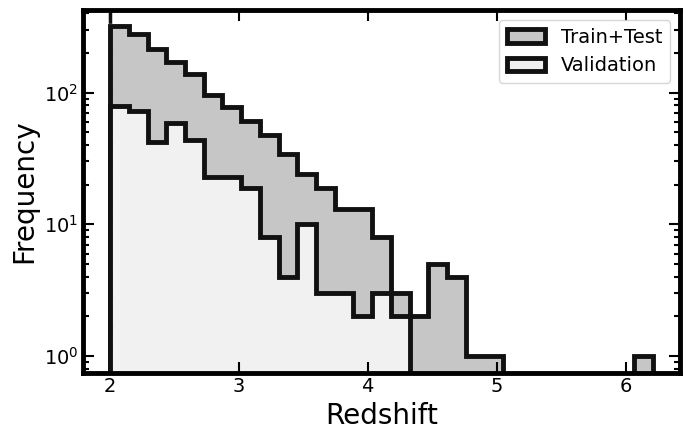

In [15]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [16]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use SMOGN for data augmentation at high redshifts

In [17]:
if run_smoter_flag:
    backup_train_df = train_df.copy()

In [18]:
if run_smoter_flag:
    train_df = smogn.smoter(
        
        ## main arguments
        data          = backup_train_df.reset_index(drop=True),  ## pandas dataframe
        y             = target_feat,                             ## string ('header name')
        k             = 10,                                      ## positive integer (k < n), 4
        samp_method   = 'extreme',                               ## string ('balance' or 'extreme')
        drop_na_col   = False,
        drop_na_row   = False,
        under_samp    = True,
        seed          = gv.seed,
        replace       = False,
    
        ## phi relevance arguments
        rel_thres     = 0.85,                                    ## positive real number (0 < R < 1), 0.5
        rel_method    = 'auto',                                  ## string ('auto' or 'manual')
        rel_xtrm_type = 'both',                                  ## string ('low' or 'both' or 'high')
        rel_coef      = 2.00                                     ## positive real number (0 < R), 2.85
    )

In [19]:
if run_smoter_flag:
    print('Shape of new used data (after SMOGN)')
    print('-' * 40)
    print(f'Data for Modeling (Train and Test): {train_df.shape}')
    print('-' * 40)

In [20]:
if run_smoter_flag:
    fig             = plt.figure(figsize=(7,4.5))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='log')
    
    min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
    max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
    score_bins = np.linspace(min_score, max_score, 40)
    
    ax1.hist(train_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
             lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='SMOGN Train')
    ax1.hist(backup_train_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
             lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.75, label='Original Train')
    
    ax1.axvline(x=redshift_low_lim, ls='--', c='k', lw=2.5)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    # ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()

---

## Use Correlation matrix to discard some features

In [21]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [22]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [23]:
rsd_vals

K_W3        620.684507
z_y         368.713920
r_i         177.192892
i_z         147.018668
g_r         137.778616
i_y         136.189574
g_i         121.526208
y_W1        111.095570
r_z         108.173177
r_y         105.196204
g_z          89.631888
g_y          88.721132
z_W1         85.468645
y_W2         73.799771
W1_W2        71.720583
i_W1         70.017457
r_W1         65.896571
g_W1         65.527183
z_W2         60.450692
i_W2         54.209445
r_W2         51.805307
g_W2         51.735980
H_W3         45.563484
y_J          44.749219
y_H          41.167131
z_J          40.686805
i_J          38.815330
z_H          37.579689
r_J          36.690067
i_H          36.059994
g_J          35.653503
J_W3         34.851925
r_H          34.223328
g_H          33.460565
y_K          33.080185
z_K          30.485128
i_K          29.626931
y_W3         28.503215
r_K          28.365296
g_K          28.114645
z_W3         25.979816
i_W3         25.485873
g_W3         25.176319
W2_W3      

In [24]:
correlation = norm_train_test_df.corr()

In [25]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [26]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [27]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [28]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [29]:
list_drop_corr

['g_H',
 'y_H',
 'i_H',
 'r_H',
 'z_H',
 'gmag',
 'ymag',
 'imag',
 'rmag',
 'zmag',
 'J_W2',
 'J_W1',
 'K_W2',
 'K_W1',
 'g_K',
 'y_K',
 'i_K',
 'r_K',
 'z_K',
 'J_W3',
 'g_W4',
 'W3mag',
 'y_W4',
 'i_W4',
 'r_W4',
 'z_W4',
 'W2mproPM',
 'W1mproPM',
 'H_W2',
 'H_W1',
 'H_W3',
 'W3_W4',
 'Jmag',
 'Hmag',
 'H_W4',
 'r_J',
 'g_W2',
 'i_J',
 'g_W3',
 'W1_W4',
 'r_W3',
 'y_W3',
 'i_W3',
 'z_W3',
 'J_K',
 'r_W2',
 'W2_W4',
 'y_W2',
 'i_W2',
 'W1_W3',
 'W4mag',
 'z_J',
 'z_W2',
 'r_W1',
 'g_i',
 'i_W1',
 'r_y',
 'g_J',
 'g_y',
 'Kmag',
 'W2_W3',
 'i_y',
 'g_z']

In [30]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [31]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [32]:
corr_discard = norm_train_test_discard.corr()

In [33]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z      Z           1.000000
y_W1   z_W1        0.742572
z_W1   g_W1        0.732927
y_W1   y_J         0.699428
y_J    band_num    0.696326
i_z    r_z         0.687098
r_i    r_z         0.660773
g_W1   g_r         0.657563
J_W4   K_W4        0.656369
       H_K         0.615998
g_W1   y_W1        0.612371
K_W4   K_W3        0.557087
W1_W2  Z           0.520710
K_W3   y_J         0.520431
z_W1   y_J         0.516644
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

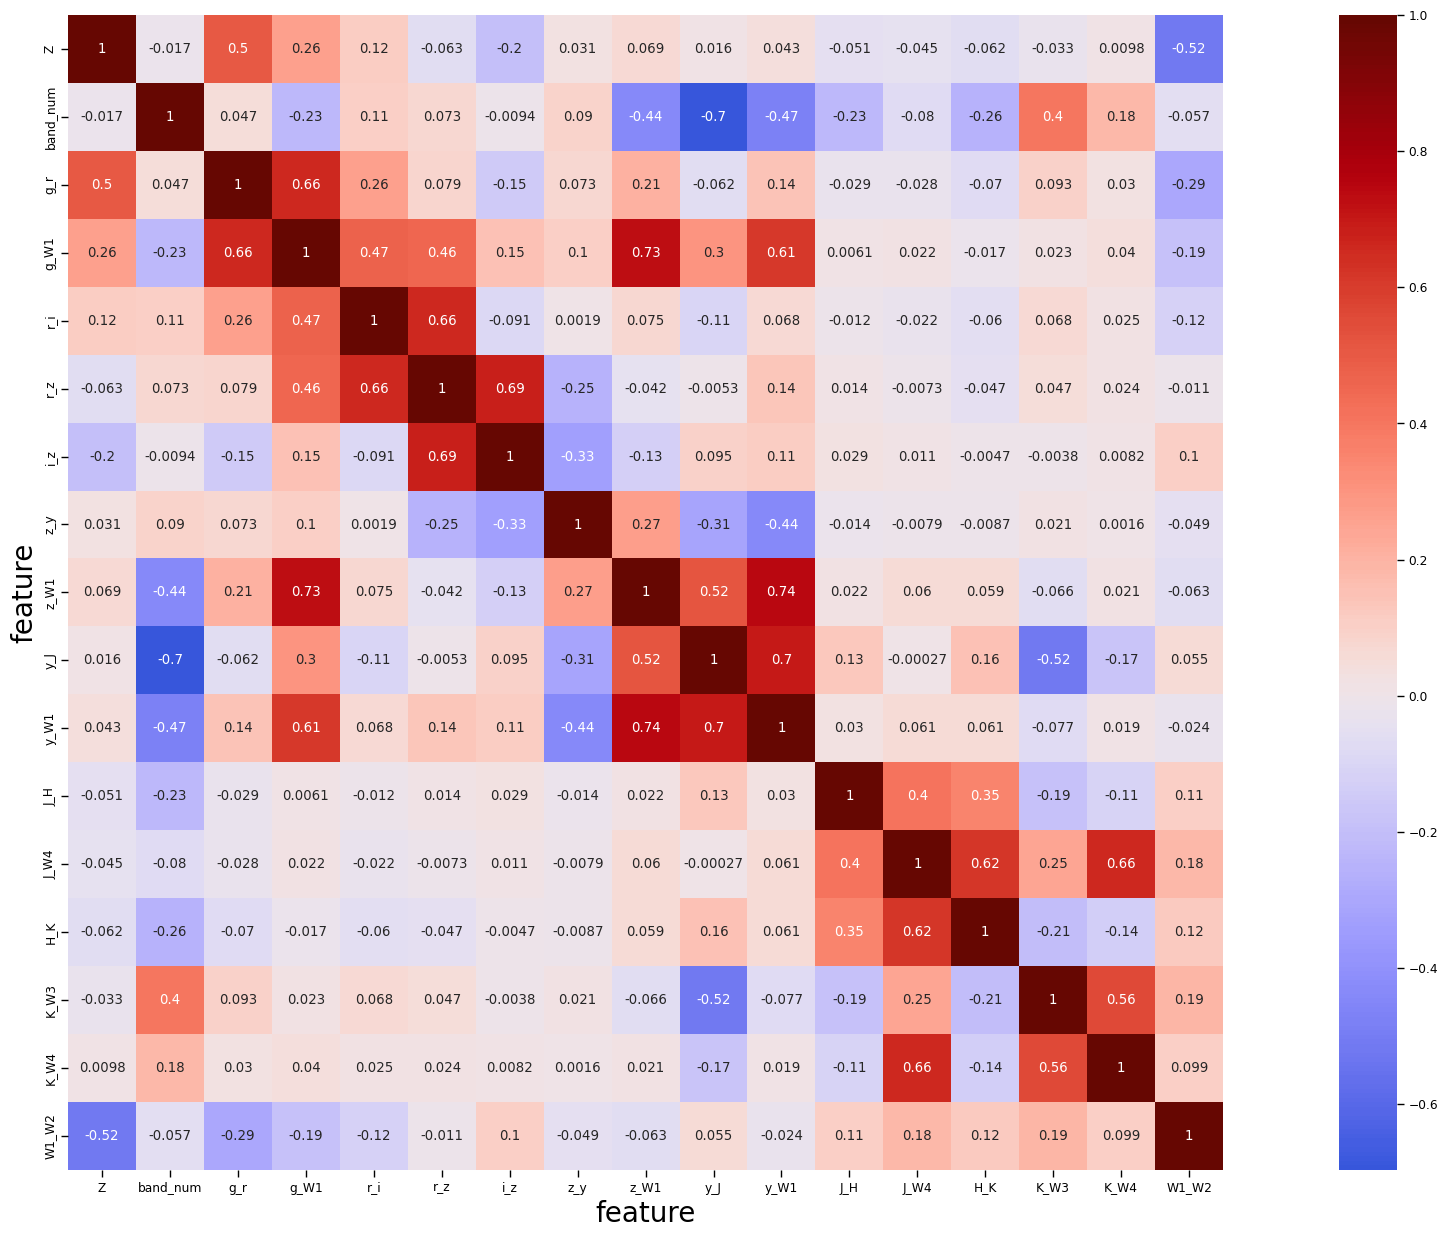

In [34]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [35]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [36]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [37]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
band_num  y_J         0.448772
J_W4      K_W4        0.443146
band_num  y_W1        0.346848
K_W3      K_W4        0.261754
y_W1      z_W1        0.256603
band_num  z_y         0.251482
z_W1      y_W1        0.243540
y_J       band_num    0.218561
z_W1      g_W1        0.212860
y_J       y_W1        0.205596
z_y       y_J         0.189978
y_W1      y_J         0.175209
K_W4      J_W4        0.162594
g_W1      z_W1        0.158682
J_W4      H_K         0.141821
band_num  z_W1        0.125080
K_W3      y_J         0.106870
y_W1      g_W1        0.104524
z_y       y_W1        0.098056
dtype: float64

In [38]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [39]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [40]:
list_drop_pps = []

In [41]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [42]:
list_drop_pps

[]

In [43]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [44]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [45]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0,regression,True,mean absolute error,0.085552,0.090020,DecisionTreeRegressor()
1,g_r,Z,0,regression,True,mean absolute error,0.085552,0.102761,DecisionTreeRegressor()
2,g_W1,Z,0,regression,True,mean absolute error,0.085552,0.119389,DecisionTreeRegressor()
3,r_i,Z,0,regression,True,mean absolute error,0.085552,0.118291,DecisionTreeRegressor()
4,r_z,Z,0,regression,True,mean absolute error,0.085552,0.111658,DecisionTreeRegressor()
5,i_z,Z,0,regression,True,mean absolute error,0.085552,0.107253,DecisionTreeRegressor()
6,z_y,Z,0,regression,True,mean absolute error,0.085552,0.121578,DecisionTreeRegressor()
7,z_W1,Z,0,regression,True,mean absolute error,0.085552,0.124044,DecisionTreeRegressor()
8,y_J,Z,0,regression,True,mean absolute error,0.085552,0.111549,DecisionTreeRegressor()
9,y_W1,Z,0,regression,True,mean absolute error,0.085552,0.119796,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [46]:
['g_r', 'g_W1', 'r_i', 'r_z', 'i_z', 'z_y', 'z_W1', 'y_W1', 'W1_W2']

['g_r', 'g_W1', 'r_i', 'r_z', 'i_z', 'z_y', 'z_W1', 'y_W1', 'W1_W2']

In [47]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('band_num')  # After Boruta
final_feats.remove('y_J')       # After Boruta
final_feats.remove('J_H')       # After Boruta
final_feats.remove('J_W4')      # After Boruta
final_feats.remove('H_K')       # After Boruta
final_feats.remove('K_W3')      # After Boruta
final_feats.remove('K_W4')      # After Boruta

In [48]:
# feats_2_discard = list_drop_corr + list_drop_pps
feats_2_discard = list_drop_corr + list_drop_pps + ['band_num', 'y_J', 'J_H', 'J_W4', 'H_K', 'K_W3', 'K_W4']

Boruta discards one feature.

In [49]:
exp_radio = pyr.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta',\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(1061, 80)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1061, 9)"


In [50]:
pyr.get_config('X').columns

Index(['g_r', 'g_W1', 'r_i', 'r_z', 'i_z', 'z_y', 'z_W1', 'y_W1', 'W1_W2'], dtype='object')

In [51]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [52]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fb9a1ade670>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [53]:
metric_2_opt          = 's_mad'
final_selection_reg   = ['rf', 'catboost', 'gbr', 'et', 'xgboost', 'dummy']
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, small sample => too slow)
n_models              = 5
top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort=metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z          = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2308,0.1274,0.3493,0.5246,0.0906,0.0893,0.2341,0.0678,0.3493,0.0938,0.0791,0.4050
catboost,CatBoost Regressor,0.2303,0.1206,0.3396,0.5445,0.0886,0.0889,0.2396,0.0687,0.3396,0.0901,0.0791,0.3310
gbr,Gradient Boosting Regressor,0.2344,0.1270,0.3492,0.5281,0.0901,0.0900,0.2406,0.0691,0.3492,0.0927,0.0716,0.0320
et,Extra Trees Regressor,0.2283,0.1215,0.3407,0.5399,0.0886,0.0886,0.2416,0.0682,0.3407,0.0912,0.0669,0.2960
xgboost,Extreme Gradient Boosting,0.2462,0.1352,0.3626,0.4930,0.0954,0.0951,0.2554,0.0725,0.3626,0.0962,0.0952,7.7630
dummy,Dummy Regressor,0.3920,0.2737,0.5186,-0.0123,0.1339,0.1476,0.5140,0.1513,0.5186,0.1271,0.2450,0.0050


Thus, we select `rf` as meta learner (based upon $\sigma_{\mathrm{MAD}}$).

Thus, we stack the models.

In [54]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0],\
                                   optimize=metric_2_opt, restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2553,0.1520,0.3899,0.5448,0.1030,0.1026,0.2250,0.0618,0.3899,0.1158,0.1215
1,0.2806,0.2421,0.4921,0.4188,0.1138,0.0984,0.2637,0.0835,0.4921,0.0984,0.0849
2,0.2067,0.0850,0.2916,0.5839,0.0797,0.0838,0.2198,0.0664,0.2916,0.0815,0.0849
3,0.2437,0.1193,0.3453,0.3128,0.0935,0.0980,0.2521,0.0687,0.3453,0.1001,0.1038
4,0.2347,0.1016,0.3188,0.4064,0.0872,0.0924,0.2723,0.0787,0.3188,0.0909,0.0566
5,0.2050,0.0773,0.2781,0.7497,0.0745,0.0773,0.2039,0.0604,0.2781,0.0757,0.0566
6,0.2018,0.0756,0.2750,0.7453,0.0761,0.0787,0.2122,0.0594,0.2750,0.0751,0.0660
7,0.1873,0.0712,0.2669,0.7255,0.0709,0.0718,0.1785,0.0489,0.2669,0.0706,0.0472
8,0.2384,0.1092,0.3305,0.5611,0.0905,0.0959,0.2924,0.0794,0.3305,0.0969,0.0943


In [55]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping=True, optimize=metric_2_opt,\
                               search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2463,0.1466,0.3829,0.5610,0.0994,0.0973,0.2037,0.0606,0.3829,0.1112,0.0841
1,0.2767,0.2477,0.4977,0.4055,0.1148,0.0949,0.2598,0.0802,0.4977,0.0976,0.0943
2,0.2003,0.0788,0.2808,0.6142,0.0763,0.0801,0.1999,0.0593,0.2808,0.0771,0.0566
3,0.2341,0.1116,0.3341,0.3569,0.0909,0.0925,0.2177,0.0631,0.3341,0.0948,0.0943
4,0.2267,0.0969,0.3112,0.4342,0.0848,0.0884,0.2313,0.0638,0.3112,0.0881,0.0472
5,0.1867,0.0682,0.2611,0.7792,0.0667,0.0673,0.1992,0.0593,0.2611,0.0659,0.0283
6,0.2117,0.0854,0.2923,0.7121,0.0796,0.0805,0.2120,0.0639,0.2923,0.0778,0.0849
7,0.1825,0.0799,0.2827,0.6920,0.0736,0.0682,0.1655,0.0496,0.2827,0.0707,0.0472
8,0.2477,0.1268,0.3561,0.4905,0.0959,0.0985,0.2721,0.0710,0.3561,0.1044,0.0849


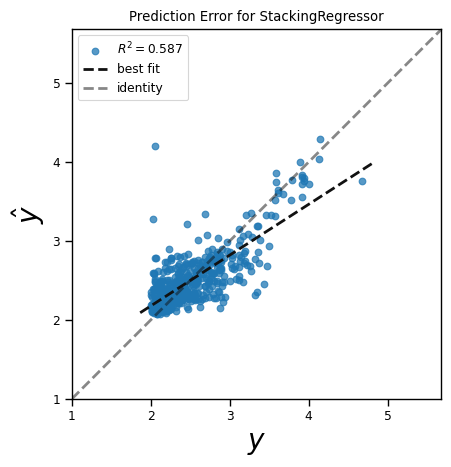

In [56]:
pyr.plot_model(tuned_z_reg, plot='error')

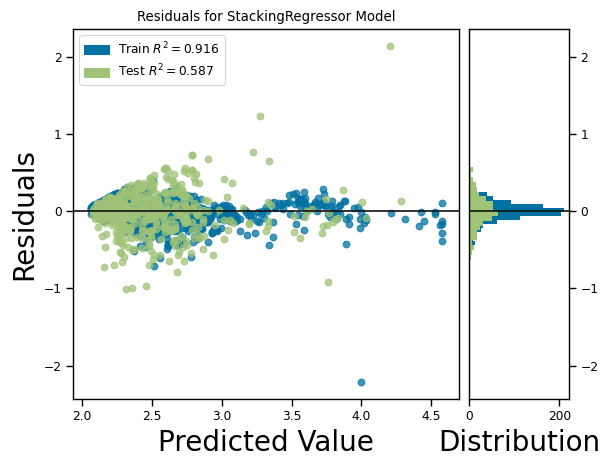

In [57]:
pyr.plot_model(tuned_z_reg, plot='residuals')

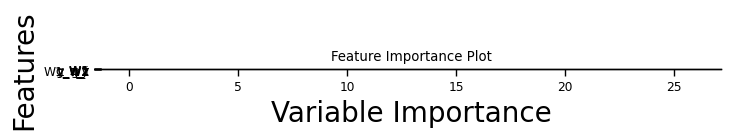

In [58]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [59]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mae
max_depth,7
max_features,0.9899385314840731
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,2.1233685952728822e-06
min_impurity_split,None
min_samples_leaf,5


In [60]:
plt.rcParams.update(plt.rcParamsDefault)

In [61]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2002,0.0833,0.2887,0.5867,0.0788,0.0792,0.2035,0.0562,0.2887,0.0819,0.0618


,Z,Label
count,469.000000,469.000000
mean,2.523352,2.514202
std,0.449570,0.376153
min,2.000000,2.076417
25%,2.193000,2.263833
50%,2.399000,2.431042
75%,2.740000,2.665972
max,4.680000,4.285750


In [62]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2002,0.0833,0.2887,0.5867,0.0788,0.0792,0.2035,0.0562,0.2887,0.0819,0.0618


In [ ]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

In [64]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2002,0.0833,0.2887,0.5867,0.0788,0.0792,0.2035,0.0562,0.2887,0.0819,0.0618


,Z,Label
count,469.000000,469.000000
mean,2.523352,2.514202
std,0.449570,0.376153
min,2.000000,2.076417
25%,2.193000,2.263833
50%,2.399000,2.431042
75%,2.740000,2.665972
max,4.680000,4.285750


In [65]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.high_z_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [50]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.high_z_model)  # for z >= 4, regression_z_may_31_4_2022

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [51]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [52]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [53]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [54]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [55]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [56]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for gbr...
Calculating for et...
Calculating for xgboost...


catboost                gbr                 et            xgboost           
   Feature Importance Feature Importance Feature Importance Feature Importance
0      g_r  25.848041     g_r  35.552734   W1_W2  26.472875   W1_W2  30.542120
1    W1_W2  21.357628   W1_W2  27.769432     g_r  26.407233     g_r  21.121660
2      i_z  10.615315     i_z   8.046319     r_z   8.140944     i_z   9.893892
3      z_y   9.864772     z_y   7.136608     i_z   7.949210    z_W1   9.174251
4      r_z   8.428255     r_z   6.669232     z_y   6.978500     r_z   8.513080
5     g_W1   7.192162    g_W1   6.152976    g_W1   6.963114    g_W1   6.026156
6      r_i   6.295190    z_W1   3.819840     r_i   6.101642     z_y   6.009297
7     y_W1   5.342871     r_i   3.031457    z_W1   6.064858    y_W1   5.343194
8     z_W1   5.055765    y_W1   1.821402    y_W1   4.921625     r_i   3.376352

In [57]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,27.498131
1,xgboost,27.450860
2,gbr,20.304677
3,z_y,4.961167
4,catboost,4.160381
5,r_i,3.101408
6,i_z,2.326141
7,g_r,2.066460
8,y_W1,1.966348
9,W1_W2,1.965981


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
g_r	25.902
W1_W2	21.559
i_z	10.557
z_y	9.773
r_z	8.409
g_W1	7.169
r_i	6.233
y_W1	5.305
z_W1	5.094


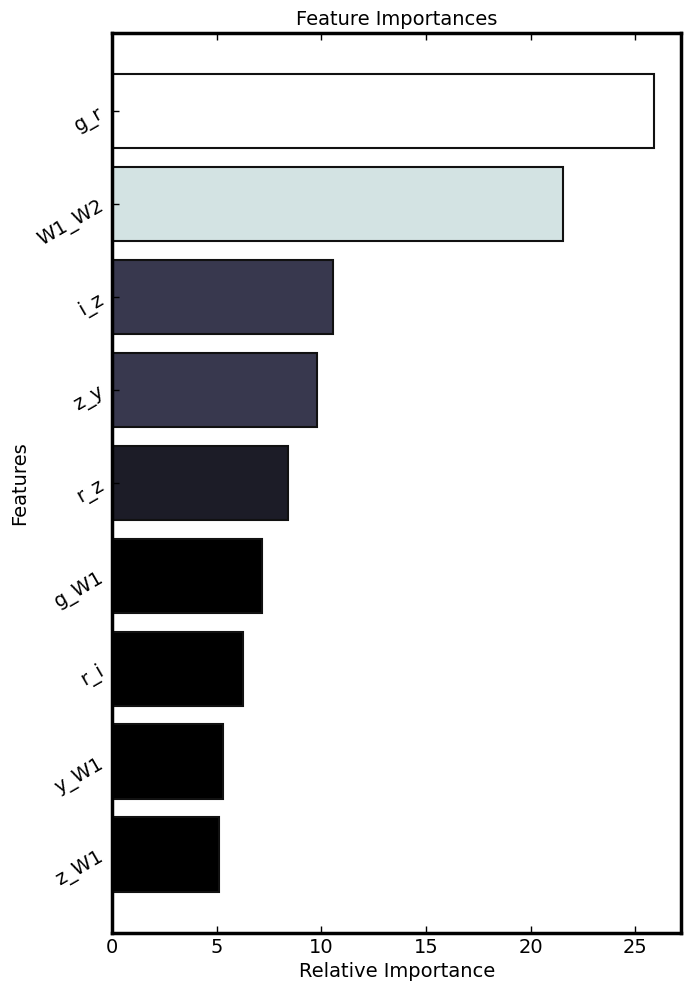

In [58]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = gf.get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        if redshift_low_lim == 3.7:
            plt.savefig(gv.plots_path + 'feat_imp_regression_z_08.pdf', bbox_inches='tight')
        elif redshift_low_lim == 3.6:
            plt.savefig(gv.plots_path + 'feat_imp_regression_z_09.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [59]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'rf', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,rf,catboost,gbr,et,xgboost
n_estimators,36,NaN,100.0000,100.0000,100.0000
max_depth,7,NaN,3.0000,NaN,6.0000
min_impurity_decrease,0.0000,NaN,0.0000,0.0000,NaN
max_features,0.9899,NaN,None,auto,NaN
bootstrap,True,NaN,NaN,False,NaN
criterion,mae,NaN,NaN,mse,NaN
min_samples_split,6,NaN,2.0000,2.0000,NaN
min_samples_leaf,5,NaN,1.0000,1.0000,NaN
learning_rate,NaN,0.0413,0.1000,NaN,0.3000
depth,NaN,6.0000,NaN,NaN,NaN


---

In [60]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 1,061
Size of test set is  469


In [61]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.2145,0.0923,0.3038,0.5383,0.0817,0.0846


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.1001,0.0230,0.1517,0.9158,0.0388,0.0384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.2002,0.0833,0.2887,0.5867,0.0788,0.0792


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.1308,0.0415,0.2037,0.8350,0.0543,0.0509


In [62]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,397.000000,397.000000
mean,2.529806,2.547843
std,0.447671,0.396105
min,2.000000,2.062597
25%,2.193000,2.269597
50%,2.446000,2.469861
75%,2.732000,2.705458
max,4.247000,4.456361


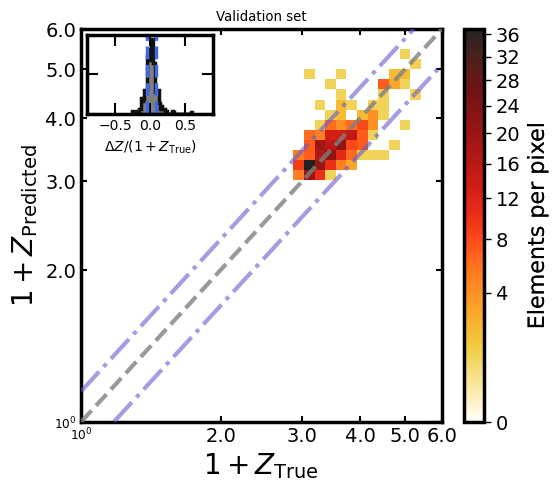

In [63]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_09.pdf', bbox_inches='tight')
plt.show()

In [64]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [65]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [66]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [67]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [68]:
out_frac_train      = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
out_frac_test       = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
out_frac_train_test = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
out_frac_valid      = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [69]:
metrics_z = np.array([[sigma_mad_train,      sigma_nmad_train,      sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [sigma_mad_test,       sigma_nmad_test,       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [sigma_mad_train_test, sigma_nmad_train_test, sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [sigma_mad_valid,      sigma_nmad_valid,      sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [70]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Validation'],\
                            columns=['\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [71]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

,σ MAD,σ NMAD,σ z,σ z N,η
Train,0.1045,0.0297,0.1517,0.0379,0.0019
Test,0.2035,0.0562,0.2887,0.0819,0.0618
Train+Test,0.1241,0.0360,0.2037,0.0552,0.0203
Validation,0.2312,0.0667,0.3038,0.0847,0.0605


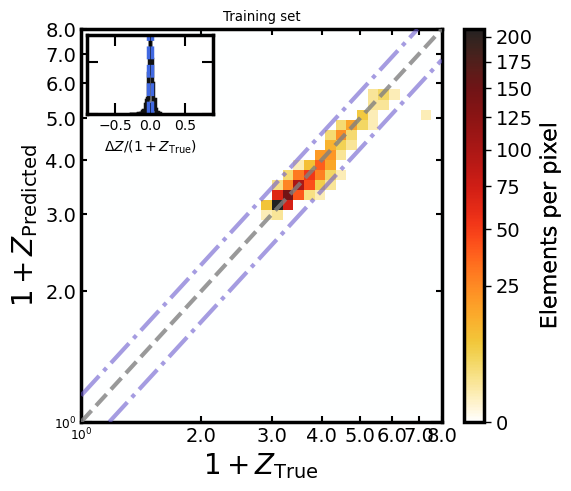

In [72]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_09.pdf', bbox_inches='tight')
plt.show()

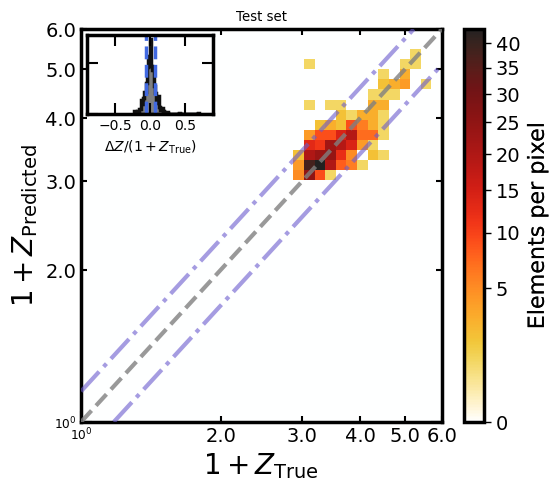

In [73]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_09.pdf', bbox_inches='tight')
plt.show()

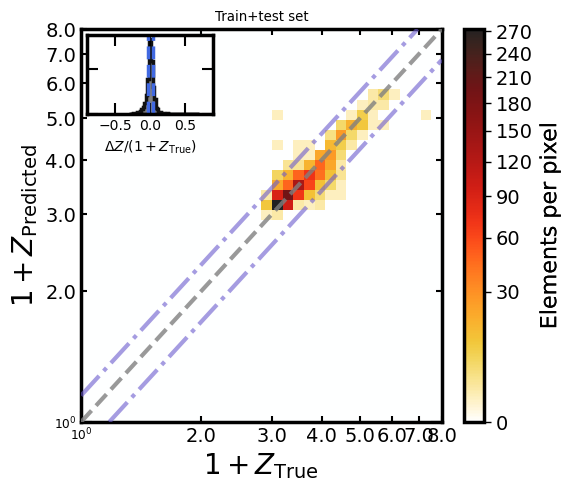

In [74]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Train+test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_test_redshift_09.pdf', bbox_inches='tight')
plt.show()

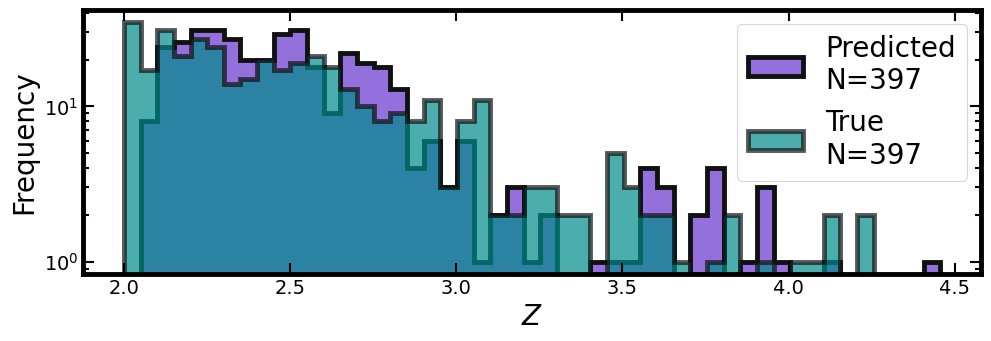

In [75]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, target_feat] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_09.pdf')
plt.show()